In [ ]:
import keras
import numpy as np

from keras.layers import Conv2D, Input, Conv2DTranspose, BatchNormalization, Dropout
from keras.models import Model
import keras.backend as K
from coord import CoordinateChannel2D

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from GeneratorClass import DataGeneratorEncoders_MLP, DataGeneratorEncoders_CNN

def get_data_by_ID(np_dict, ID):
    return np_dict["sample-{0}/noisy".format(ID)], np_dict["sample-{0}/orig".format(ID)]

def get_data_by_ID_orig(np_dict, ID):
    data = np_dict["sample-{0}/orig".format(ID)]
    return data, data

In [3]:
fileVer = 5
dataset_size = 5000
data_percentage = 1.

img_size = 256
n_width = img_size
n_height = img_size
n_depth = 1

#n_epochs = 70
#learning_rate = 1e-3
#lr_decay = 0.002
batch_size = 16

filePath = "data/img_{0}x{0}_v{1}/img_{0}x{0}.npz".format(
    img_size, fileVer)
loaded = np.load(filePath)


def get_data_fn(ID):
    return get_data_by_ID(loaded, ID)

def get_data_orig_fn(ID):
    return get_data_by_ID_orig(loaded, ID)


In [4]:
# %% list of ids
total_dataset_size = int(dataset_size * data_percentage)

id_mask = np.arange(0, total_dataset_size)
np.random.shuffle(id_mask)

lista_ID_training = id_mask[0:int(0.7 * total_dataset_size)]
lista_ID_validation = id_mask[int(0.7 * total_dataset_size):int(0.8 * total_dataset_size)]
lista_ID_test = id_mask[int(0.8 * total_dataset_size):total_dataset_size]

create generators to feed data into model

In [5]:
params_CNN = {'get_data_fn': get_data_fn,
              'dim': (n_height, n_width),
              'batch_size': batch_size,
              'n_channels': n_depth,
              'shuffle': True}

VAE_generator_CNN_train = DataGeneratorEncoders_CNN(lista_ID_training, **params_CNN)
VAE_generator_CNN_val = DataGeneratorEncoders_CNN(lista_ID_validation, **params_CNN)
VAE_generator_CNN_test = DataGeneratorEncoders_CNN(lista_ID_test, **params_CNN)


# CNN

In [29]:
n_layers = 4
n_filters = [ 128, 64, 64, 32]
kernel_size = 7

input_layer = Input(shape=(n_height, n_width, n_depth), name="input_layer")
layer = input_layer
layer = CoordinateChannel2D()(layer)

layer_vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=layer, pooling=None)
layer = layer_vgg16.get_layer("block4_conv3").output


#decoder
layer = Conv2DTranspose(filters=n_filters[0], kernel_size=kernel_size, strides=1, padding='same',
                            activation='relu',
                            name="dec_conv_{0}".format(0))(layer)
layer = BatchNormalization(name="batch_norm_dec_{}".format(0))(layer)


layer = Conv2DTranspose(filters=n_filters[1], kernel_size=kernel_size, strides=2, padding='same',
                            activation='relu',
                            name="dec_conv_{0}".format(1))(layer)
layer = BatchNormalization(name="batch_norm_dec_{}".format(1))(layer)


layer = Conv2DTranspose(filters=n_filters[2], kernel_size=kernel_size, strides=2, padding='same',
                            activation='relu',
                            name="dec_conv_{0}".format(2))(layer)
layer = BatchNormalization(name="batch_norm_dec_{}".format(2))(layer)


layer = Conv2DTranspose(filters=n_filters[3], kernel_size=kernel_size, strides=2, padding='same',
                            activation='relu',
                            name="dec_conv_{0}".format(3))(layer)
layer = BatchNormalization(name="batch_norm_dec_{}".format(3))(layer)

#build output layer
output_layer = Conv2DTranspose(filters=1, kernel_size=kernel_size, padding='same', activation='linear',
                               name="output_layer")(layer)

model_CNN = Model(input_layer, output_layer)

for layer in model_CNN.layers[:len(model_CNN.layers)-9]:
    layer.trainable = False

#print summary of the model
model_CNN.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 256, 256, 1)       0         
_________________________________________________________________
coordinate_channel2d_5 (Coor (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
__________

In [30]:
steps_per_epoch = len(VAE_generator_CNN_train)
steps_per_epoch_val = len(VAE_generator_CNN_val)

In [31]:
def get_decay(steps, epochs, ratio=1e-3):
    decay = (1/ratio - 1)/(steps*epochs)
    return decay

In [35]:
final_val = 1e-3
n_epochs = 3

learning_rate = 1e-3
#lr_decay = get_decay(steps_per_epoch, n_epochs, final_val)
lr_decay = 0

#compile model
model_CNN.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=learning_rate, decay=lr_decay),
                  metrics=['accuracy'])

In [37]:
model_CNN.fit_generator(generator=VAE_generator_CNN_train, steps_per_epoch=steps_per_epoch,
                            validation_data=VAE_generator_CNN_val, validation_steps=steps_per_epoch_val,
                            epochs=n_epochs,
                            use_multiprocessing=True,
                            workers=0, verbose=1)

model_CNN.save('CNN_vgg16_v5.h5') 

Epoch 1/3
218/218 [==============================] - 116s 530ms/step - loss: 6.5721e-04 - acc: 0.7840 - val_loss: 4.7534e-04 - val_acc: 0.7819
Epoch 2/3
218/218 [==============================] - 113s 518ms/step - loss: 3.2982e-04 - acc: 0.7840 - val_loss: 2.1604e-04 - val_acc: 0.7819
Epoch 3/3
218/218 [==============================] - 114s 521ms/step - loss: 2.4705e-04 - acc: 0.7840 - val_loss: 1.6666e-04 - val_acc: 0.7819


In [23]:
def plot_sample(sample_id, generator, model, file_name=None):

    saple_id=sample_id
    model=model
    generator=generator

    data_tmp = np.array(generator.__getitem__(saple_id))[:,0,:,:,0]

    X1_plt,X2_plt = data_tmp

    X1=X1_plt.reshape((1,n_height,n_width,1))
    X2=X2_plt.reshape((1,n_height,n_width,1))

    Y_test_pred1 = model.predict(X1).reshape((n_height, n_width))
    Y_test_pred2 = model.predict(X2).reshape((n_height, n_width))

    indexes_1=np.where(Y_test_pred2>1)
    indexes_2=np.where(Y_test_pred2<0)
    Y_test_pred2_tmp=Y_test_pred2
    Y_test_pred2_tmp[indexes_1]=1
    Y_test_pred2_tmp[indexes_2]=0

    indexes_1=np.where(Y_test_pred1>1)
    indexes_2=np.where(Y_test_pred1<0)
    Y_test_pred1_tmp=Y_test_pred1
    Y_test_pred1_tmp[indexes_1]=1
    Y_test_pred1_tmp[indexes_2]=0

    fig_, axis_ = plt.subplots(2, 3, figsize=(12, 8))
    axis_[0, 0].imshow(X2_plt, cmap="Greys_r")
    axis_[0, 0].set_title("original")
    axis_[1, 0].imshow(X1_plt, cmap="Greys_r")
    axis_[1, 0].set_title("noisy")
    axis_[0, 1].imshow(Y_test_pred2_tmp, cmap="Greys_r")
    axis_[0, 1].set_title("reconstructed_orig")
    axis_[1, 1].imshow(Y_test_pred1_tmp, cmap="Greys_r")
    axis_[1, 1].set_title("reconstruct_noisy")
    axis_[0, 2].imshow(X2_plt, cmap="Greys_r")
    axis_[0, 2].set_title("target")
    axis_[1, 2].imshow(Y_test_pred1_tmp, cmap="Greys_r")
    axis_[1, 2].set_title("reconstructed")
    
    fig_.tight_layout()
    plt.show()
    if file_name is not None:
        fig_.savefig("{0}.png".format(file_name), dpi=300)

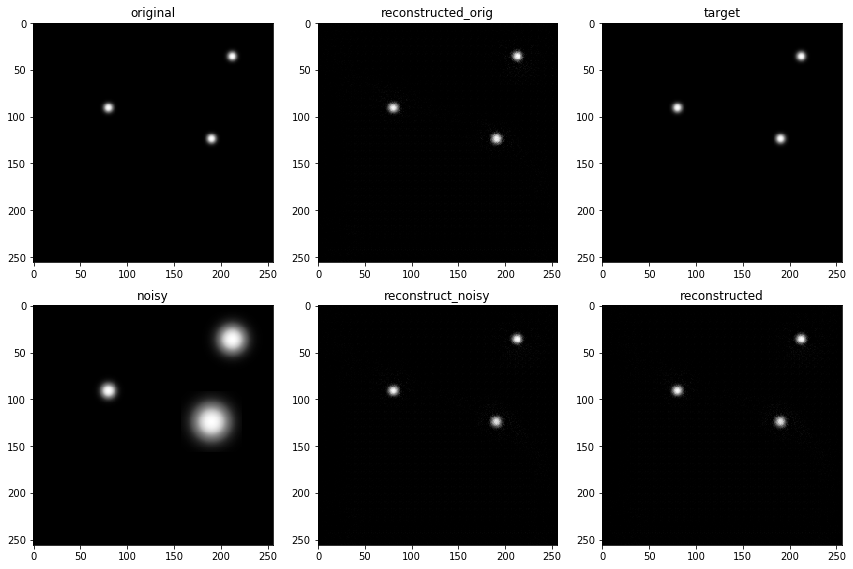

In [71]:
sample_id=30

plot_sample(sample_id, VAE_generator_CNN_test, model_CNN, "fig1_vgg16c_09")


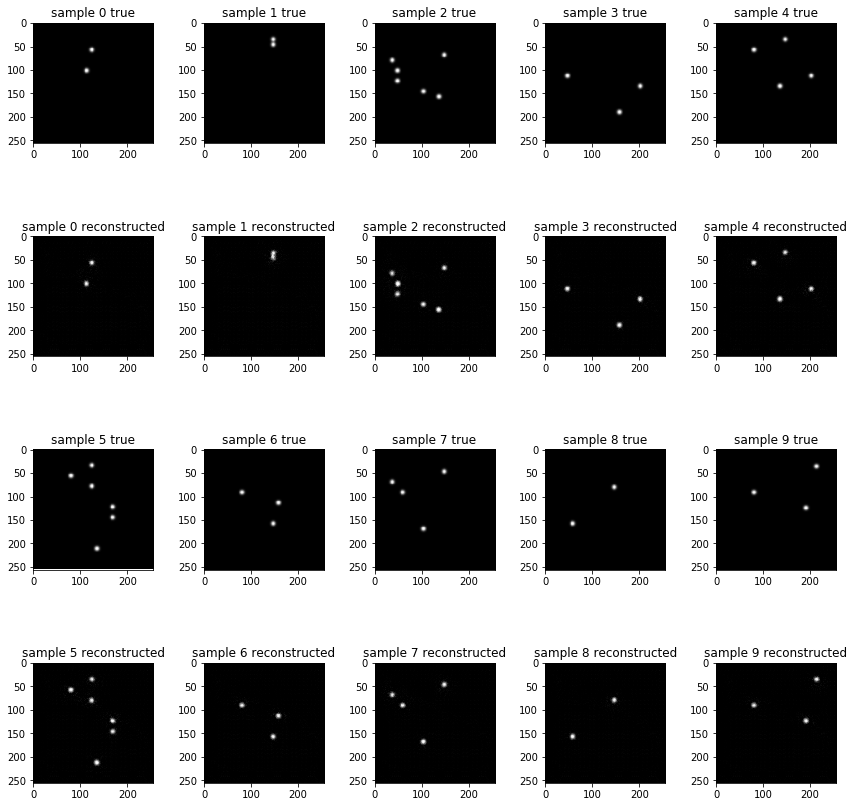

In [73]:
sample_ids=np.linspace(0,30,10,dtype=np.int32)

inputs=np.zeros((len(sample_ids),n_height, n_width))
reconstructed=np.zeros((len(sample_ids),n_height, n_width))

for i in np.arange(len(sample_ids)):

    data_tmp = np.array(VAE_generator_CNN_test.__getitem__(sample_ids[i]))[:,0,:,:,0]

    _,Xi_plt = data_tmp
    
    Xi=Xi_plt.reshape((1,n_height,n_width,1))

    Y_test_pred_i = model_CNN.predict(Xi).reshape((n_height, n_width))
    
    indexes_1=np.where(Y_test_pred_i>1)
    indexes_2=np.where(Y_test_pred_i<0)
    Y_test_pred_tmp=Y_test_pred_i
    Y_test_pred_tmp[indexes_1]=1
    Y_test_pred_tmp[indexes_2]=0
    
    inputs[i,]=Xi_plt
    reconstructed[i,]=Y_test_pred_tmp
    

fig3, axis3 = plt.subplots(4, 5, figsize=(12, 12
                                         ))
for i in range(5):
    axis3[0, i].imshow(inputs[i], cmap="Greys_r")
    axis3[0, i].set_title("sample {0} true".format(i))
    axis3[1, i].imshow(reconstructed[i], cmap="Greys_r")
    axis3[1, i].set_title("sample {0} reconstructed".format(i))
    
for i in range(5):
    axis3[2, i].imshow(inputs[i+5], cmap="Greys_r")
    axis3[2, i].set_title("sample {0} true".format(i+5))
    axis3[3, i].imshow(reconstructed[i+5], cmap="Greys_r")
    axis3[3, i].set_title("sample {0} reconstructed".format(i+5))    

fig3.tight_layout()
plt.show()
fig3.savefig("fig2_vgg16c.png", dpi=300)